<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [121]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [122]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

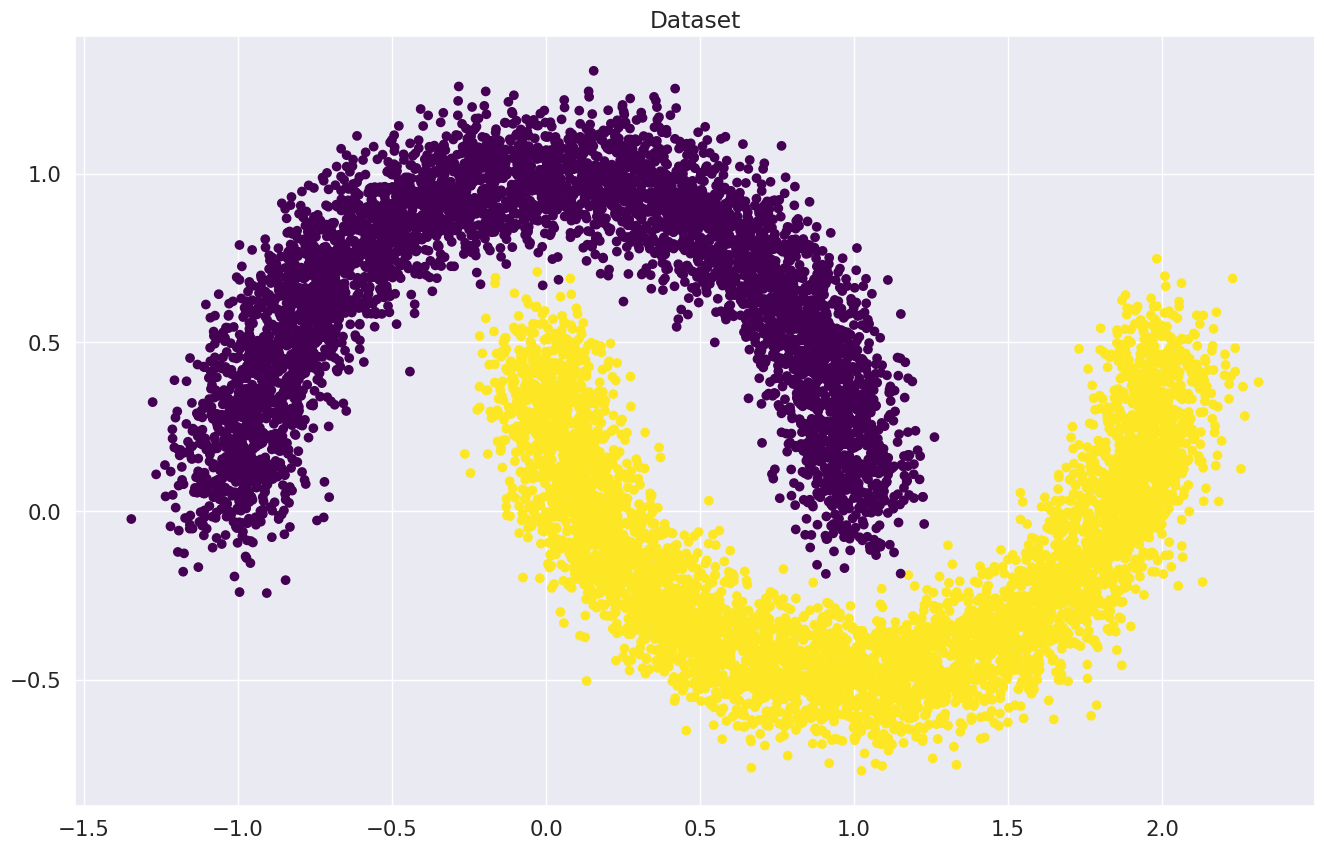

In [123]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [124]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [125]:
X_train_t =  torch.tensor(X_train, dtype=torch.float32)
y_train_t =  torch.tensor(y_train, dtype=torch.float32)
X_val_t =  torch.tensor(X_val, dtype=torch.float32)
y_val_t =  torch.tensor(y_val, dtype=torch.float32)

Создаем `Dataset` и `DataLoader`.

In [126]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [127]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x = torch.matmul(x, self.weights)
        if self.bias:
            x += self.bias_term
        return x

In [128]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели?

In [129]:
# у модели сверху будет 3 параметра (2 веса + 1 смещение)
[param for param in linear_regression.parameters()]

[Parameter containing:
 tensor([[ 1.3941],
         [-1.8196]], requires_grad=True),
 Parameter containing:
 tensor([0.0743], requires_grad=True)]

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [130]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch)
        # считаем loss, добавляем размерность к y_batch
        loss = loss_function(outp, y_batch.unsqueeze(1))
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        # берем сигмоиду, чтобы получить вероятность
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.8125
Iteration: 100
Batch accuracy: 0.8359375
Iteration: 200
Batch accuracy: 0.828125
Iteration: 300
Batch accuracy: 0.921875
Iteration: 400
Batch accuracy: 0.890625

Iteration: 401.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 400 итераций и алгоритм сходится

### Визуализируем результаты

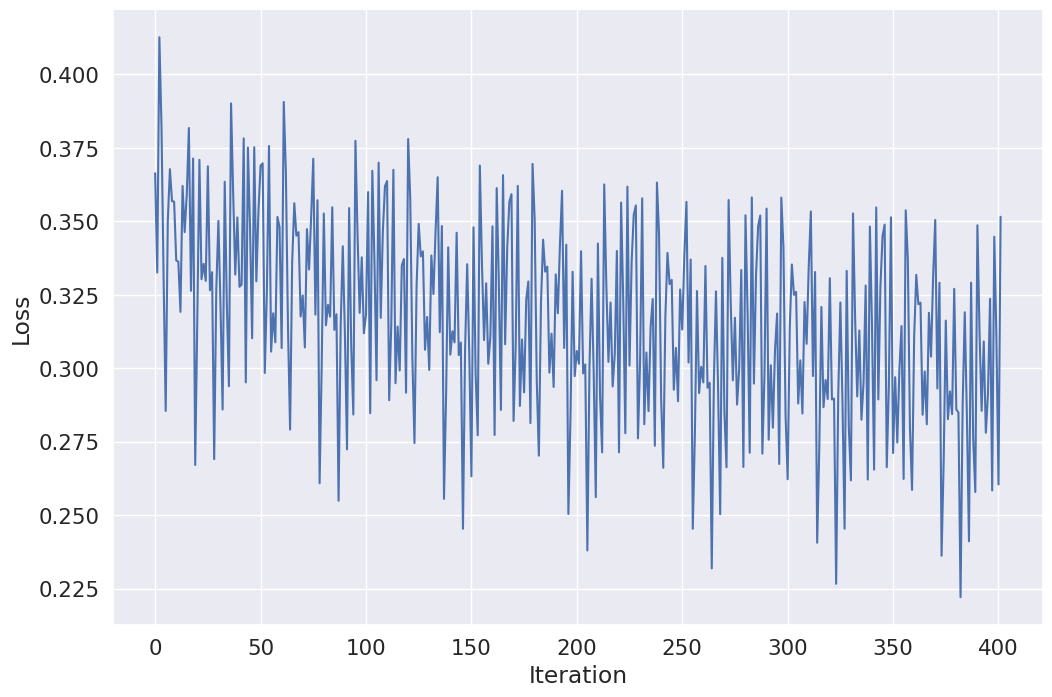

In [131]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

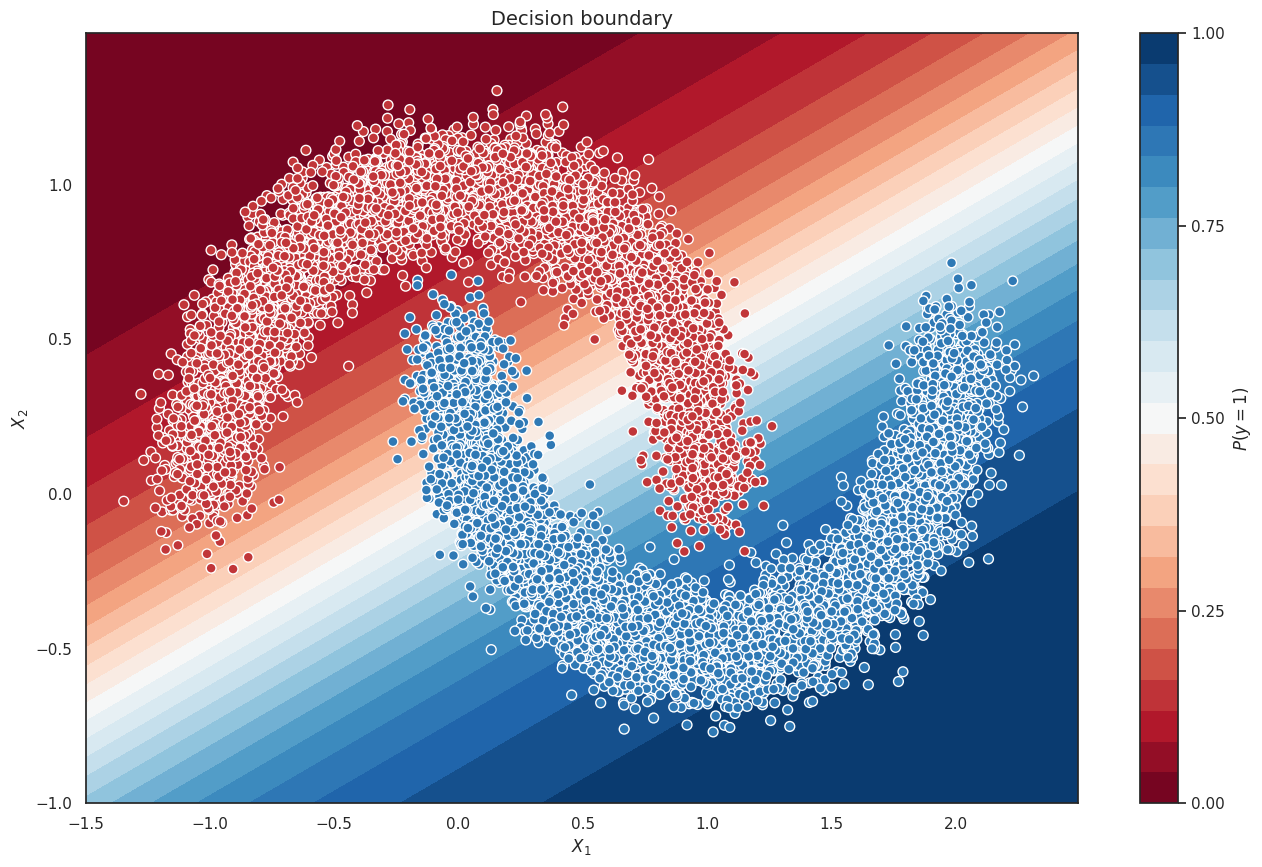

In [132]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [133]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        # получаем вероятности классов
        preds = torch.sigmoid(model(x_batch))
        # преобразуем вероятности в классы с порогом 0.5
        preds = (preds > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [134]:
from sklearn.metrics import accuracy_score

print(accuracy_score(pred, y_val))

0.8576


**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** acuracy с порогом 0.5 получается 0.8576

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [135]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as T

transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=transform, download=True)
val_dataset  = MNIST(root, train=False, transform=transform, download=True)

train_dataloader =  torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True
)
valid_dataloader =  torch.utils.data.DataLoader(
    val_dataset, batch_size=32, shuffle=True
)

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [136]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [137]:
activation = nn.ELU()

model = nn.Sequential(
    nn.Flatten(), # 28 x 28
    nn.Linear(784, 128),
    activation,
    nn.Linear(128, 128),
    activation,
    nn.Linear(128, 10),
    nn.Softmax(dim=1) # чтобы сразу вероятности выдавать
)

In [138]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [139]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [140]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
              # Устанавливаем режим обучения и обнуляем градиенты
              model.train()
              optimizer.zero_grad()
              outp = model(x_batch)
            else:
              # Устанавливаем режим оценки
              model.eval()
              with torch.no_grad():
                outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8631
Loader: valid. Accuracy: 0.923
Epoch: 2
Loader: train. Accuracy: 0.92675
Loader: valid. Accuracy: 0.9264
Epoch: 3
Loader: train. Accuracy: 0.9389666666666666
Loader: valid. Accuracy: 0.9457
Epoch: 4
Loader: train. Accuracy: 0.9452333333333334
Loader: valid. Accuracy: 0.9582
Epoch: 5
Loader: train. Accuracy: 0.9477
Loader: valid. Accuracy: 0.9444
Epoch: 6
Loader: train. Accuracy: 0.9496333333333333
Loader: valid. Accuracy: 0.9473
Epoch: 7
Loader: train. Accuracy: 0.95195
Loader: valid. Accuracy: 0.9556
Epoch: 8
Loader: train. Accuracy: 0.95355
Loader: valid. Accuracy: 0.9564
Epoch: 9
Loader: train. Accuracy: 0.9542833333333334
Loader: valid. Accuracy: 0.9623
Epoch: 10
Loader: train. Accuracy: 0.9559166666666666
Loader: valid. Accuracy: 0.9267


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [141]:
elu_accuracy = accuracy["valid"]

In [142]:
def test_activation_function(activation):
  activation = activation
  model = nn.Sequential(
  nn.Flatten(), # 28 x 28
  nn.Linear(784, 128),
  activation,
  nn.Linear(128, 128),
  activation,
  nn.Linear(128, 10),
  nn.Softmax(dim=1) # чтобы сразу вероятности выдавать
  )
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters())

  loaders = {"train": train_dataloader, "valid": valid_dataloader}

  max_epochs = 10
  accuracy = {"train": [], "valid": []}
  for epoch in range(max_epochs):
      for k, dataloader in loaders.items():
          epoch_correct = 0
          epoch_all = 0
          for x_batch, y_batch in dataloader:
              if k == "train":
                # Устанавливаем режим обучения и обнуляем градиенты
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
              else:
                # Устанавливаем режим оценки
                model.eval()
                with torch.no_grad():
                  outp = model(x_batch)
              preds = outp.argmax(-1)
              correct = (preds == y_batch).sum()
              all = y_batch.size(0)
              epoch_correct += correct.item()
              epoch_all += all
              if k == "train":
                  loss = criterion(outp, y_batch)
                  loss.backward()
                  optimizer.step()
          if k == "train":
              print(f"Epoch: {epoch+1}")
          print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
          accuracy[k].append(epoch_correct/epoch_all)
  return accuracy["valid"]


In [143]:
plain_accuracy = test_activation_function(Identical())
relu_accuracy = test_activation_function(nn.ReLU())
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU())

Epoch: 1
Loader: train. Accuracy: 0.84
Loader: valid. Accuracy: 0.8687
Epoch: 2
Loader: train. Accuracy: 0.8633666666666666
Loader: valid. Accuracy: 0.8732
Epoch: 3
Loader: train. Accuracy: 0.8623833333333333
Loader: valid. Accuracy: 0.8669
Epoch: 4
Loader: train. Accuracy: 0.8558333333333333
Loader: valid. Accuracy: 0.8775
Epoch: 5
Loader: train. Accuracy: 0.8588666666666667
Loader: valid. Accuracy: 0.8255
Epoch: 6
Loader: train. Accuracy: 0.8534833333333334
Loader: valid. Accuracy: 0.8623
Epoch: 7
Loader: train. Accuracy: 0.8530833333333333
Loader: valid. Accuracy: 0.8381
Epoch: 8
Loader: train. Accuracy: 0.84925
Loader: valid. Accuracy: 0.8504
Epoch: 9
Loader: train. Accuracy: 0.84995
Loader: valid. Accuracy: 0.8749
Epoch: 10
Loader: train. Accuracy: 0.8478166666666667
Loader: valid. Accuracy: 0.8841
Epoch: 1
Loader: train. Accuracy: 0.8541333333333333
Loader: valid. Accuracy: 0.9166
Epoch: 2
Loader: train. Accuracy: 0.92215
Loader: valid. Accuracy: 0.9359
Epoch: 3
Loader: train. Ac

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

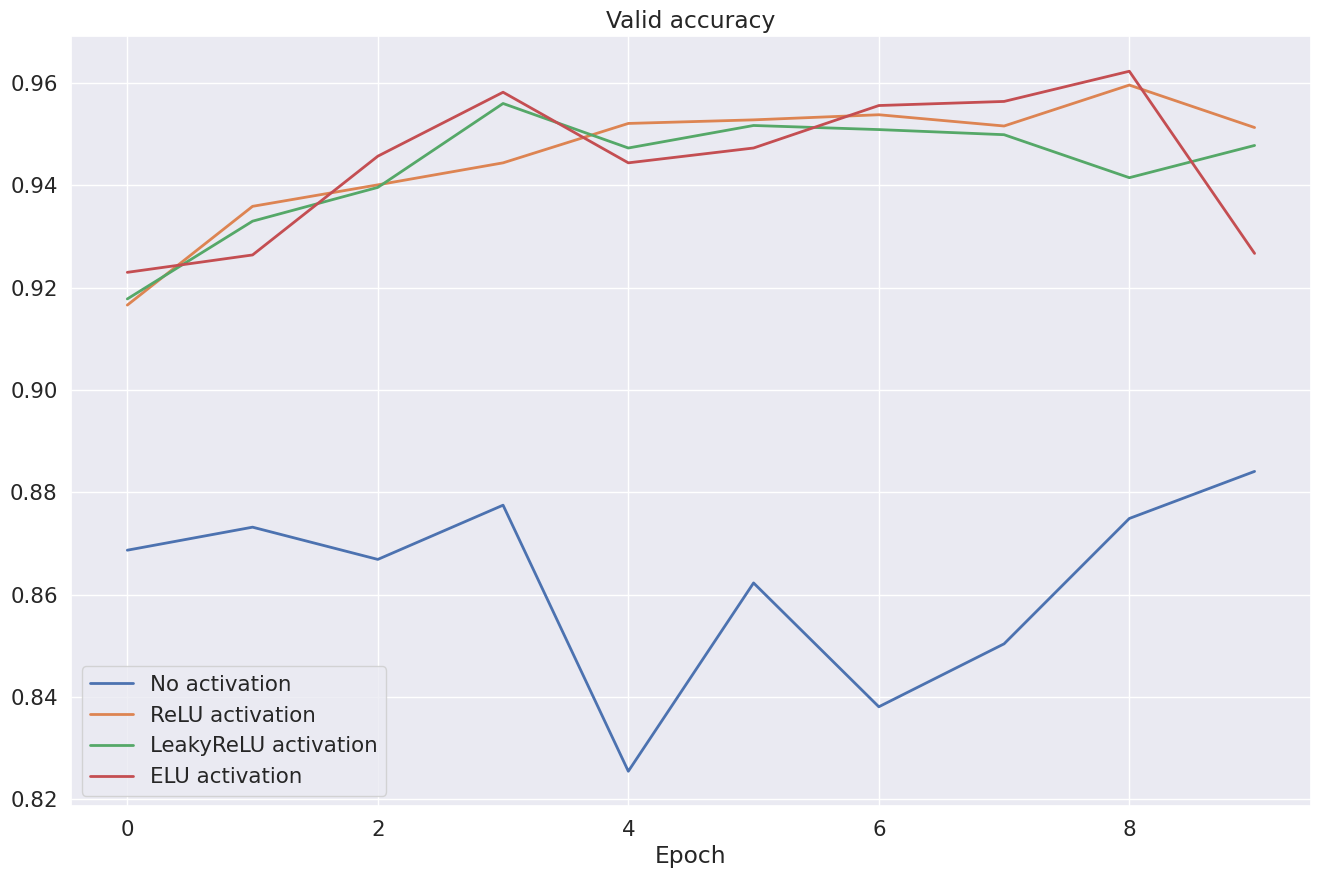

In [144]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

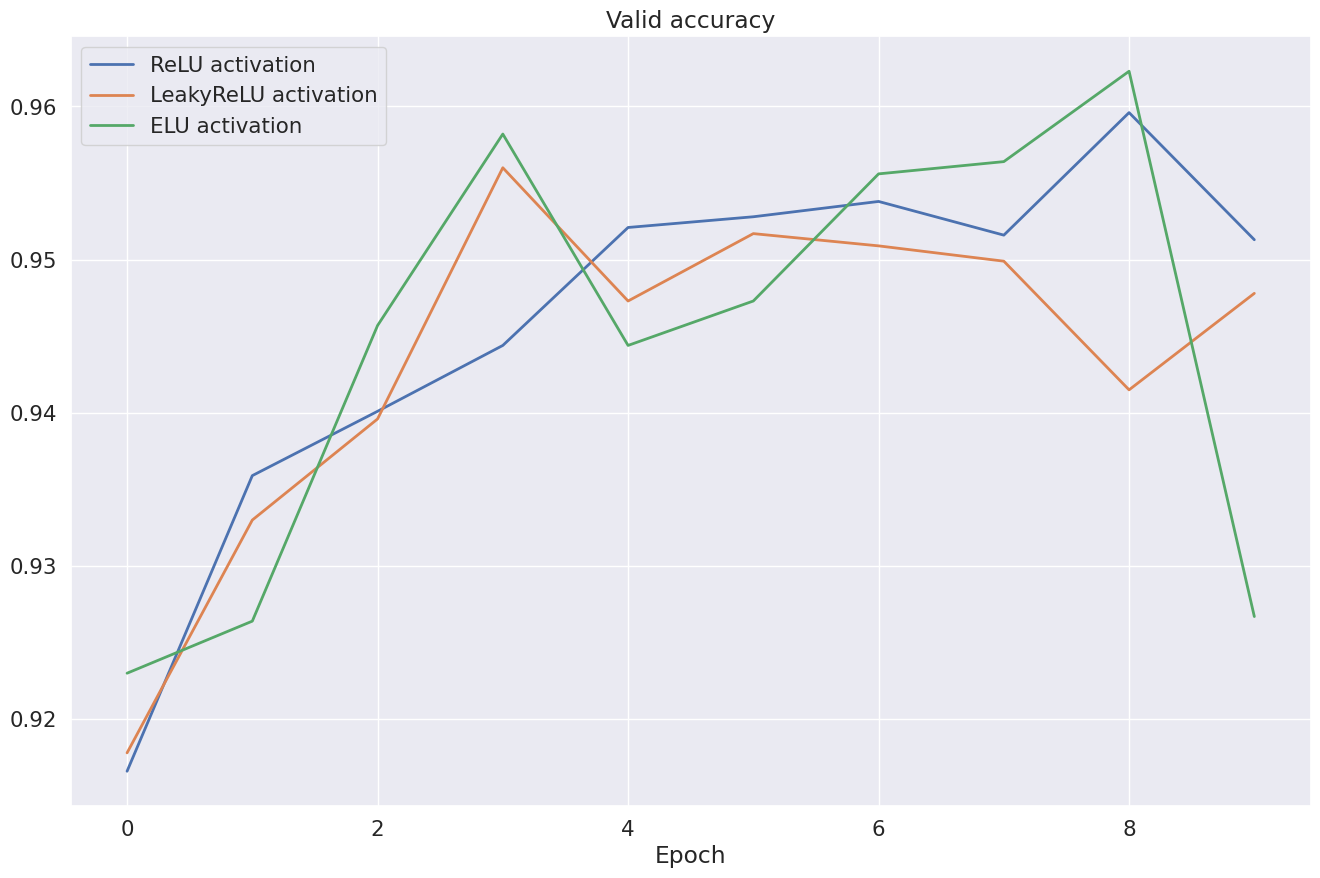

In [145]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** Лучшей оказалась RELU, у нее и график ошибки не скачет, а плавно снижается.

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [146]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2024-10-29 14:38:47--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   234KB/s    in 0.2s    

2024-10-29 14:38:47 (234 KB/s) - ‘sample_photo.jpg’ saved [49337/49337]



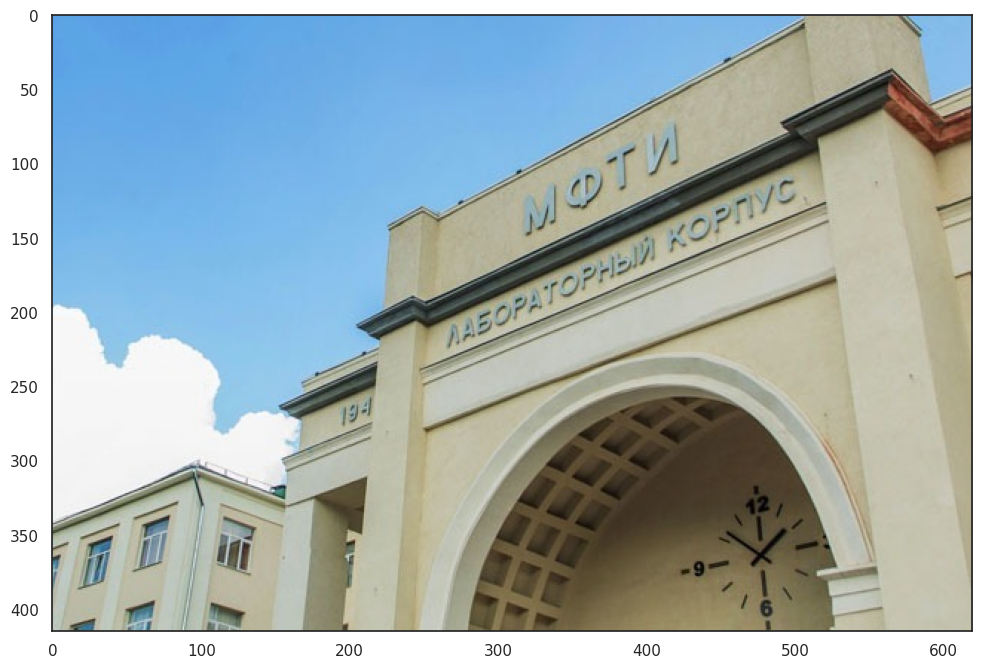

In [147]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [148]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [1, 0, 1],
    [0, -4, 0],
    [1, 0, 1]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

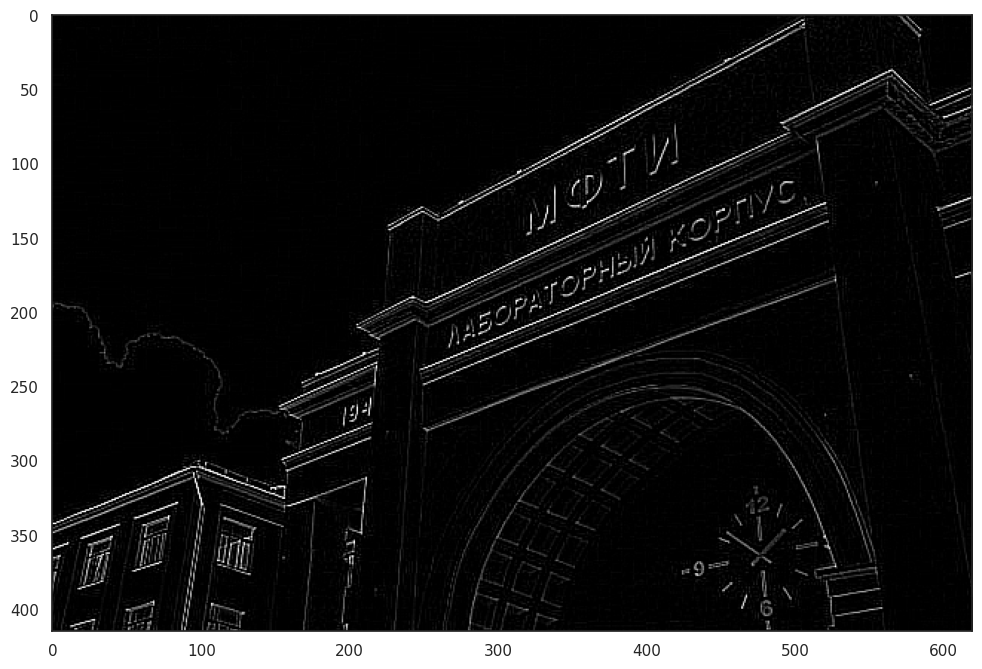

In [149]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**  
Ядро B) - 4) выделяет вертикальные границы  
Ядро А) - 3) тождественное преобразование  
Ядро Б) - 5) выделяет горизонтальные линии  
Ядро Г) - 6) выделяет все линии  
Ядро Д) - 2) увеличение резкости  
Ядро Е) - 1) размытие

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [150]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3, padding='same')     # 28 x 28
        self.pool1 = nn.MaxPool2d(2)                        # 14 x 14
        self.conv2 = nn.Conv2d(6, 16, 3, padding='same')    # 14 x 14
        self.pool2 = nn.MaxPool2d(2)                        # 7 x 7
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(16 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Проход через первый сверточный слой и активацию
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        # Проход через второй сверточный слой и активацию
        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        # Понижение размерности для подключения к полносвязным слоям
        x = self.flat(x)  # Flatten

        # Полносвязные слои с активацией
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [151]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [152]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
              # Устанавливаем режим обучения и обнуляем градиенты
              model.train()
              optimizer.zero_grad()
              outp = model(x_batch)
            else:
              # Устанавливаем режим оценки
              model.eval()
              with torch.no_grad():
                outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.93045
Loader: valid. Accuracy: 0.9805
Epoch: 2
Loader: train. Accuracy: 0.9797
Loader: valid. Accuracy: 0.9844
Epoch: 3
Loader: train. Accuracy: 0.9856
Loader: valid. Accuracy: 0.9828
Epoch: 4
Loader: train. Accuracy: 0.9887666666666667
Loader: valid. Accuracy: 0.983
Epoch: 5
Loader: train. Accuracy: 0.9907833333333333
Loader: valid. Accuracy: 0.9884
Epoch: 6
Loader: train. Accuracy: 0.9923833333333333
Loader: valid. Accuracy: 0.9888
Epoch: 7
Loader: train. Accuracy: 0.9937333333333334
Loader: valid. Accuracy: 0.9906
Epoch: 8
Loader: train. Accuracy: 0.9945833333333334
Loader: valid. Accuracy: 0.9901
Epoch: 9
Loader: train. Accuracy: 0.99535
Loader: valid. Accuracy: 0.9883
Epoch: 10
Loader: train. Accuracy: 0.9957166666666667
Loader: valid. Accuracy: 0.9871


In [153]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

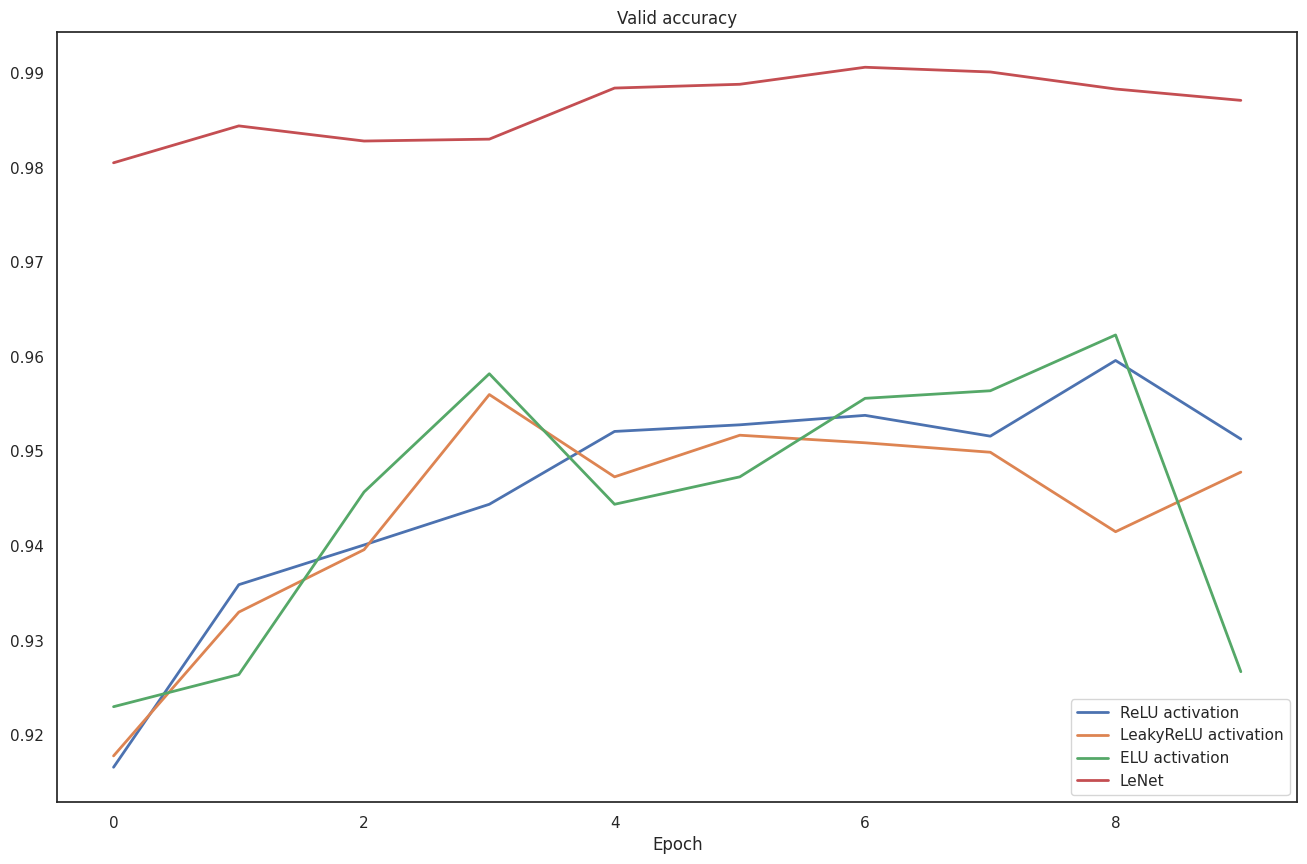

In [154]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [155]:
lenet_accuracy[-1]

0.9871

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** accuracy после обучения у Lenet 0.98